# Projections onto null space


Created by Diana L. Giraldo, Dec 2024

Last modification: Dec 2024

In [88]:
import os,sys
import numpy as np
import nibabel as nib

import torch
import torch.nn as nn

In [89]:
cwd_path = os.getcwd()
print("Working directory:", cwd_path)

Working directory: /home/vlab/null_space_projections


In [90]:
sys.path.insert(0,cwd_path)
from utils.plots import show_orthoslices
from utils.imaging_model import ModelList, MRIacq
from utils.null_projections import wilson_barret
from utils.total_variation import TotalVariation

## Load image x

In [91]:
img_fpath = os.path.join(cwd_path, 'demo_data', 'synth_HR_T1.nii.gz')

Input image: /home/vlab/null_space_projections/demo_data/synth_HR_T1.nii.gz
Image array shape: [156 186 168]
Voxel size: [1. 1. 1.]
Orientation of voxel axes: ('R', 'A', 'S')


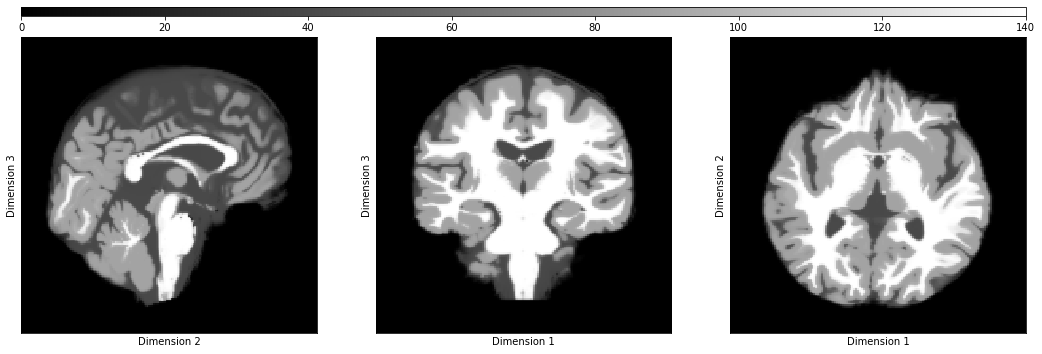

In [92]:
IMG = nib.load(img_fpath)
IMG_dim = IMG.header['dim'][1:4]
print('Input image:', img_fpath)
print('Image array shape:', IMG_dim)
print('Voxel size:', IMG.header['pixdim'][1:4])
print('Orientation of voxel axes:', nib.aff2axcodes(IMG.affine))

IMG_maxint = np.max(IMG.get_fdata())
IMG_cross = np.round(np.array(IMG_dim)/2).astype(np.int32)
show_orthoslices(IMG.get_fdata(), IMG_cross)
IMG.uncache()

In [93]:
x = torch.from_numpy(IMG.get_fdata()/IMG_maxint).float().unsqueeze(0).unsqueeze(0)

## Imaging model M

From one image to one (or more) images with lower spatial resolution

- Change of coordinates, orthogonal rotation
- Blurring and downsampling as a strided convolution.

In [94]:
slice_thickness = 5
slice_spacing = 6

# Permutation of coordinates
orients = [(0,1,2), (1,2,0)]#, (0,2,1)]

In [95]:
slice_profiles = [(slice_thickness, slice_spacing)]
sp_list = [s for s in slice_profiles for o in orients]
ori_list = orients*len(slice_profiles)
n_imgs = len(slice_profiles)*len(orients)

M = ModelList([
    MRIacq(
        perm_dims = ori_list[i],
        slice_thickness = sp_list[i][0],
        slice_spacing = sp_list[i][1],
        dimension = '3d',
        slice_model = 'smoothed-box',
        normalize_kernel = True,
    ) for i in range(n_imgs)
])

### Forward operator

In [96]:
y_list = M(x)

[78 93 14]


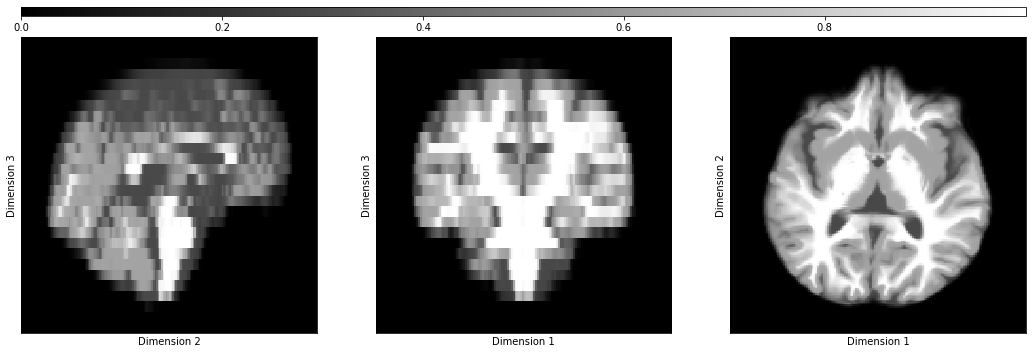

[93 84 13]


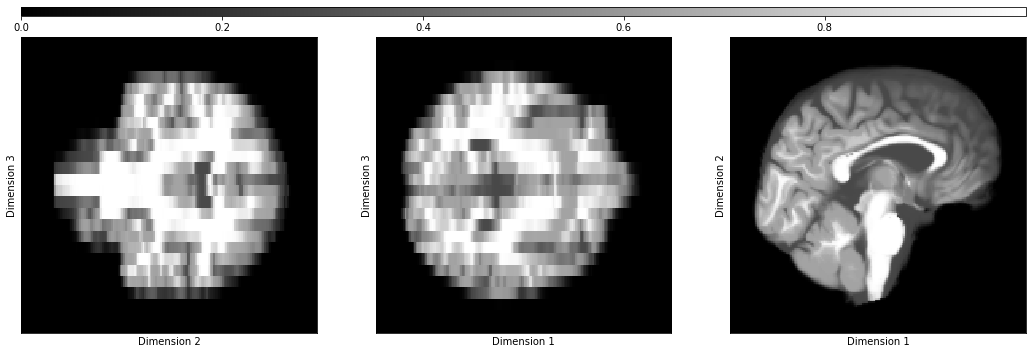

In [97]:
for i,y in enumerate(y_list):
    y_cross = np.take(IMG_cross, ori_list[i])
    y_cross[2] = (y_cross[2]/slice_spacing).astype(np.int32)
    print(y_cross)
    show_orthoslices(y.numpy().squeeze(), y_cross)

## Projections of x onto Null and Measurement space

In [59]:
# Parameter for numerical projection onto H null space
alpha = 2 # step size between 1 and 2 seems to work but it depends on M

In [60]:
x_null = wilson_barret(
    M, 
    x, 
    step = alpha, 
    tolerance = 0.01, 
    max_iter = 60,
    print_info = True,
)

tensor(427.4961)
tensor(137.5877)
tensor(63.7313)
tensor(37.1335)
tensor(22.9630)
tensor(14.3529)
tensor(8.9870)
tensor(5.6289)
tensor(3.5257)
tensor(2.2084)
tensor(1.3833)
tensor(0.8664)
tensor(0.5427)
tensor(0.3399)
tensor(0.2129)
tensor(0.1334)
tensor(0.0835)
tensor(0.0523)
tensor(0.0328)
tensor(0.0205)
tensor(0.0129)
tensor(0.0081)


In [61]:
x_meas = x - x_null

x projected onto Measurement space:


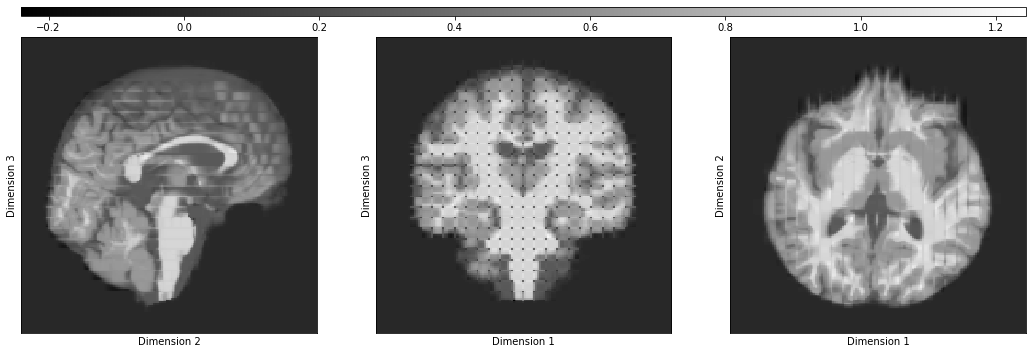

x projected onto Null space:


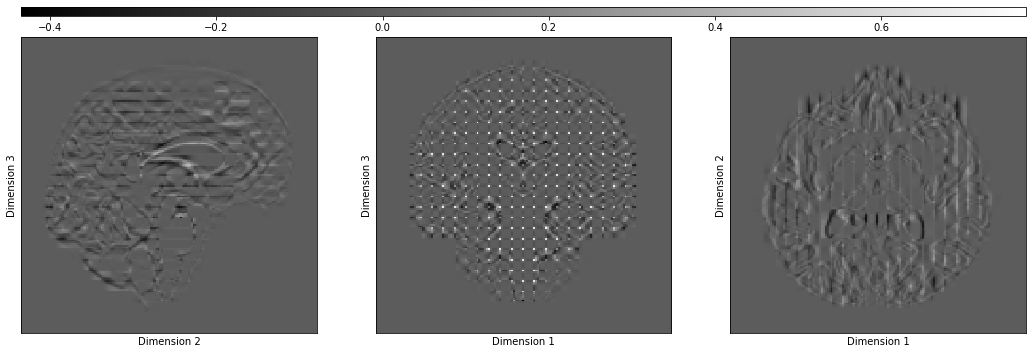

In [62]:
print("x projected onto Measurement space:")
show_orthoslices(x_meas.numpy().squeeze(), IMG_cross)

print("x projected onto Null space:")
show_orthoslices(x_null.numpy().squeeze(), IMG_cross)

## Projections of reconstructions onto Null and Measurement space

### Trilinear interpolation

In [63]:
# trilinear interpolation
interp_x = nn.functional.interpolate(y_list[0], size = tuple(IMG_dim), mode = 'trilinear', align_corners=True)

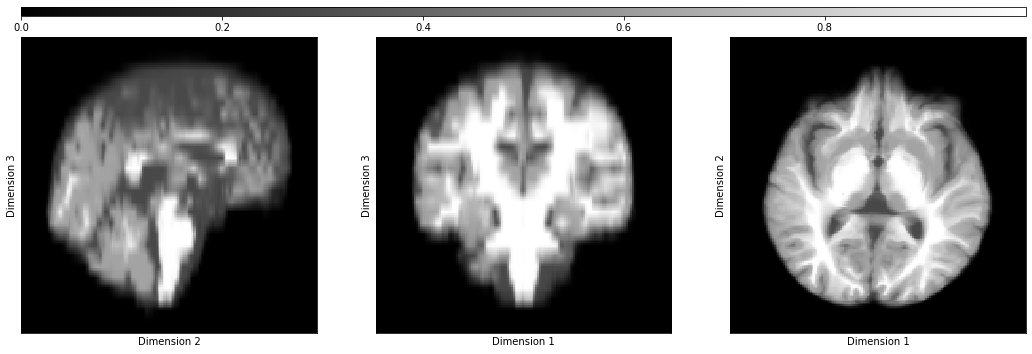

In [64]:
show_orthoslices(interp_x.numpy().squeeze(), IMG_cross)

In [65]:
interp_x_null = wilson_barret(
    M, 
    interp_x, 
    step = alpha, 
    tolerance = 0.01, 
    max_iter = 40,
    print_info = False,
)
interp_x_meas = interp_x - interp_x_null

Interpolation projected onto Measurement space:


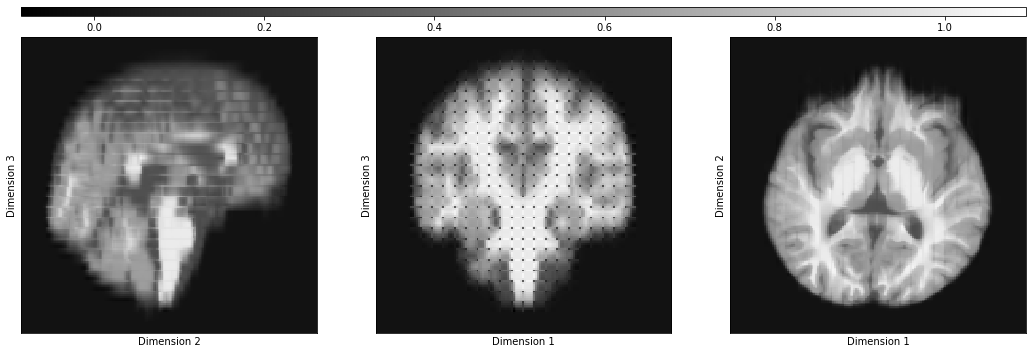

Interpolation projected onto Null space:


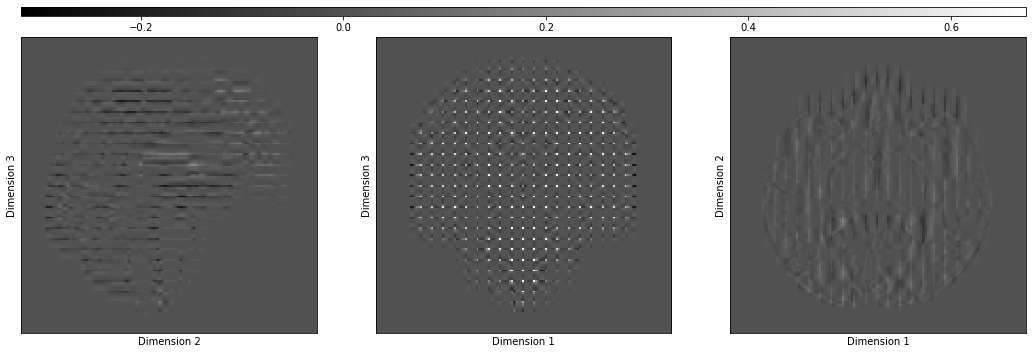

In [66]:
print("Interpolation projected onto Measurement space:")
show_orthoslices(interp_x_meas.numpy().squeeze(), IMG_cross)

print("Interpolation projected onto Null space:")
show_orthoslices(interp_x_null.numpy().squeeze(), IMG_cross)

### Model-based SRR with TV regularization

In [106]:
n_iter = 80
optim_lr = 0.1
reg_weight = 0.0000001

In [107]:
# Cost function
cost_fn = torch.nn.MSELoss()

# Regularization
reg_fn = TotalVariation()

# Object to recover
init_x = torch.zeros(tuple(IMG_dim))
rec = torch.nn.Parameter(init_x.unsqueeze(0).unsqueeze(0), requires_grad=True)

# Optimizer
optim = torch.optim.Adam([rec], lr = optim_lr)

# Run optim
for i in range(n_iter):
    Mx_list = M(rec) 
    cost = cost_fn(torch.cat([torch.flatten(Mx) for Mx in Mx_list]), torch.cat([torch.flatten(y) for y in y_list])) 
    reg = reg_fn(rec)
    loss = cost + reg_weight * reg
    loss.backward()
    optim.step()
    optim.zero_grad()
    if i % 10 == 0: print(f"Loss at {i}: {loss.item()}")

Loss at 0: 0.11247030645608902
Loss at 10: 0.005051947198808193
Loss at 20: 0.0065752253867685795
Loss at 30: 0.00211572484113276
Loss at 40: 0.0016855024732649326
Loss at 50: 0.0011882169637829065
Loss at 60: 0.001129336073063314
Loss at 70: 0.001071388483978808


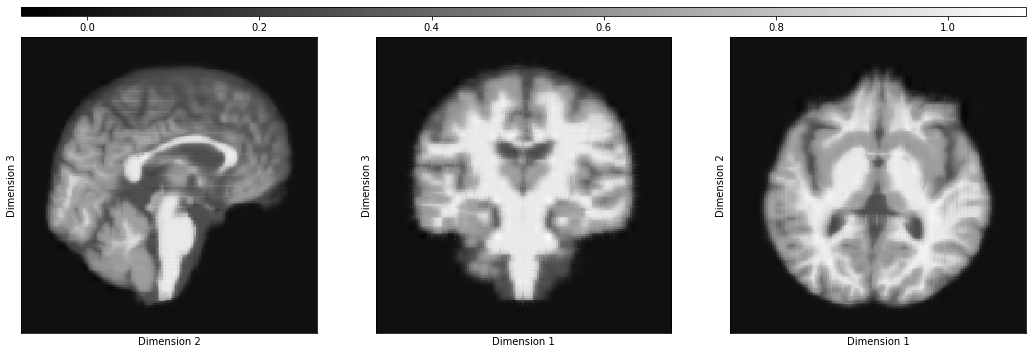

In [108]:
rec = rec.detach()
show_orthoslices(rec.numpy().squeeze(), IMG_cross)

In [109]:
rec_x_null = wilson_barret(
    M, 
    rec, 
    step = alpha, 
    tolerance = 0.01, 
    max_iter = 40,
    print_info = False,
)
rec_x_meas = rec - rec_x_null

Reconstruction projected onto Measurement space:


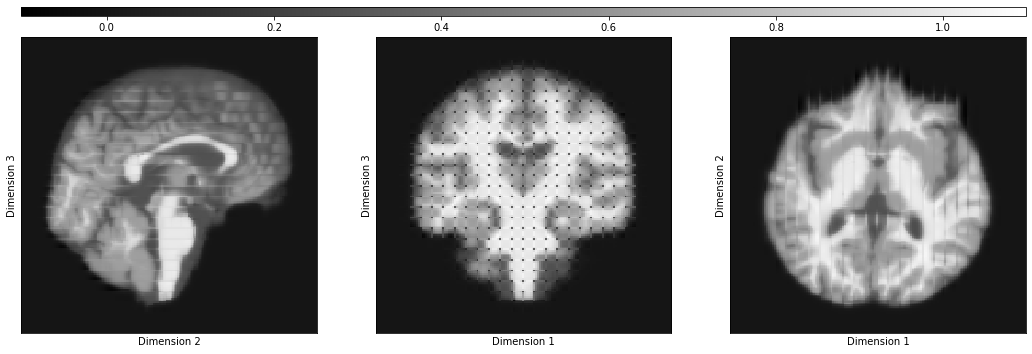

Reconstruction projected onto Null space:


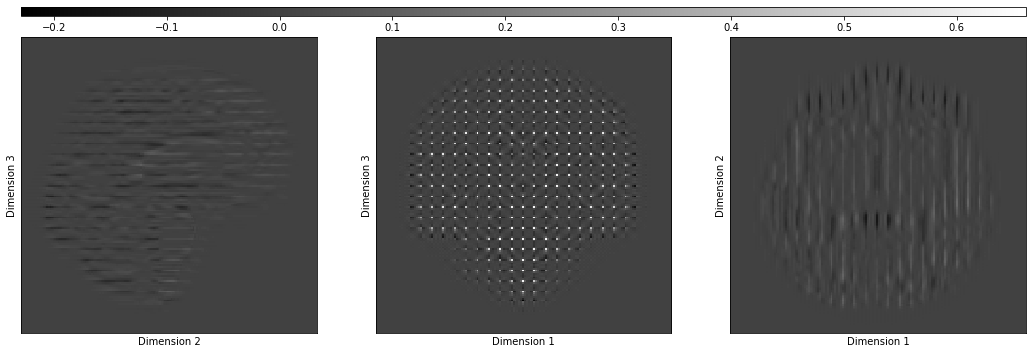

In [110]:
print("Reconstruction projected onto Measurement space:")
show_orthoslices(rec_x_meas.numpy().squeeze(), IMG_cross)

print("Reconstruction projected onto Null space:")
show_orthoslices(rec_x_null.numpy().squeeze(), IMG_cross)

### PRETTIER MRI

In [113]:
# PRETTIER 
PRETTIER_REC = nib.load(os.path.join(cwd_path, 'demo_data', 'prettierEDSR_synth.nii.gz'))
prettier_x = torch.from_numpy(PRETTIER_REC.get_fdata()/IMG_maxint).float().unsqueeze(0).unsqueeze(0)

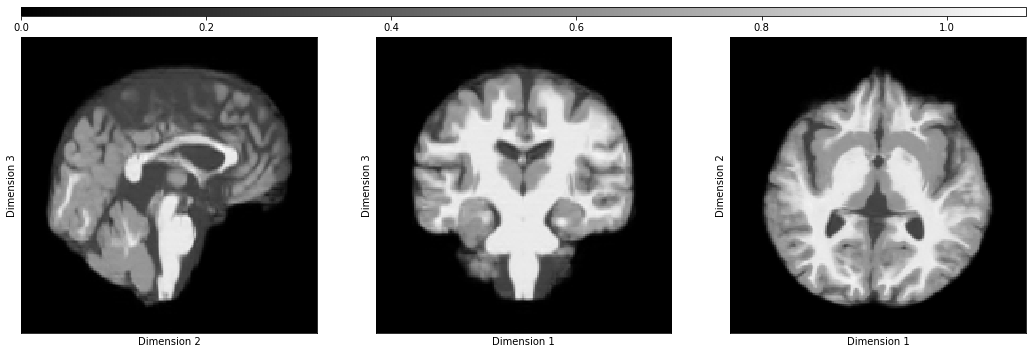

In [114]:
show_orthoslices(prettier_x.numpy().squeeze(), IMG_cross)

In [115]:
prettier_x_null = wilson_barret(
    M, 
    prettier_x, 
    step = alpha, 
    tolerance = 0.01, 
    max_iter = 40,
    print_info = False,
)
prettier_x_meas = prettier_x - prettier_x_null

PRETTIER projected onto Measurement space:


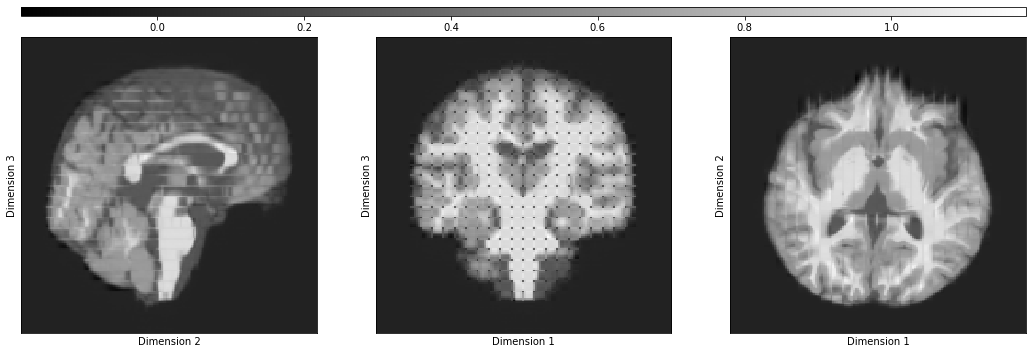

PRETTIER projected onto Null space:


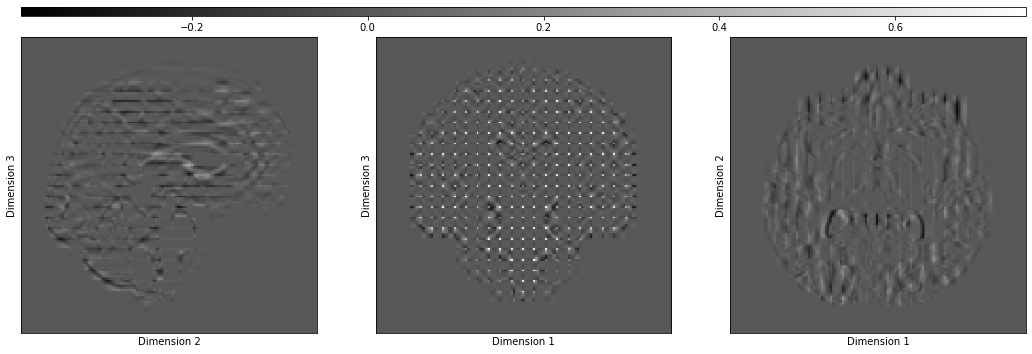

In [116]:
print("PRETTIER projected onto Measurement space:")
show_orthoslices(prettier_x_meas.numpy().squeeze(), IMG_cross)

print("PRETTIER projected onto Null space:")
show_orthoslices(prettier_x_null.numpy().squeeze(), IMG_cross)

## Hallucination map in Null space

**Hallucination map**: Difference in the reconstructed null component, what the reconstruction method is making up.

In [117]:
interp_hm_null = (interp_x_null != 0)*(interp_x_null - x_null)
mbSRR_hm_null = (rec_x_null != 0)*(rec_x_null - x_null)
prettier_hm_null = (prettier_x_null != 0)*(prettier_x_null - x_null)

Hallucination map in null space for interpolation:


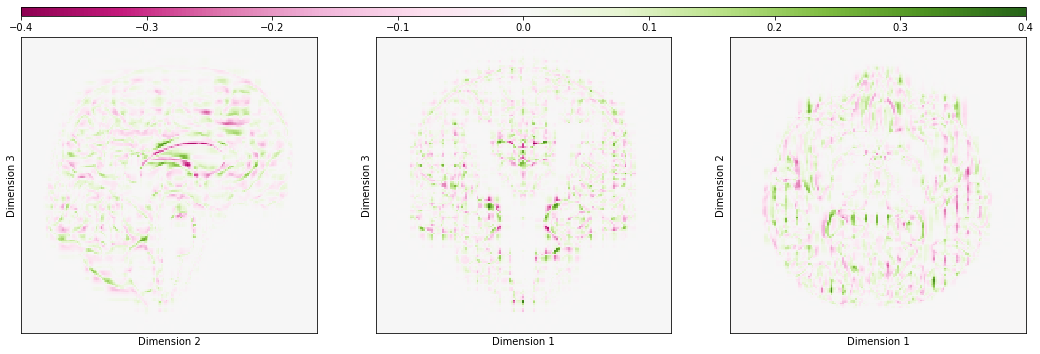

Hallucination map in null space for model-based SRR:


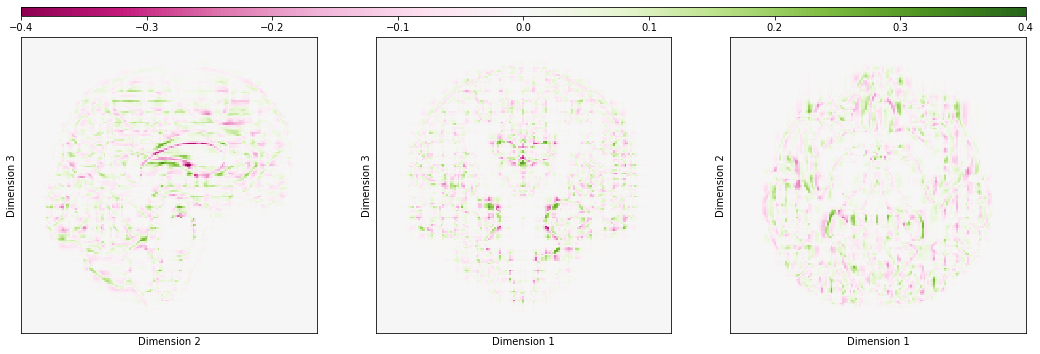

Hallucination map in null space for PRETTIER:


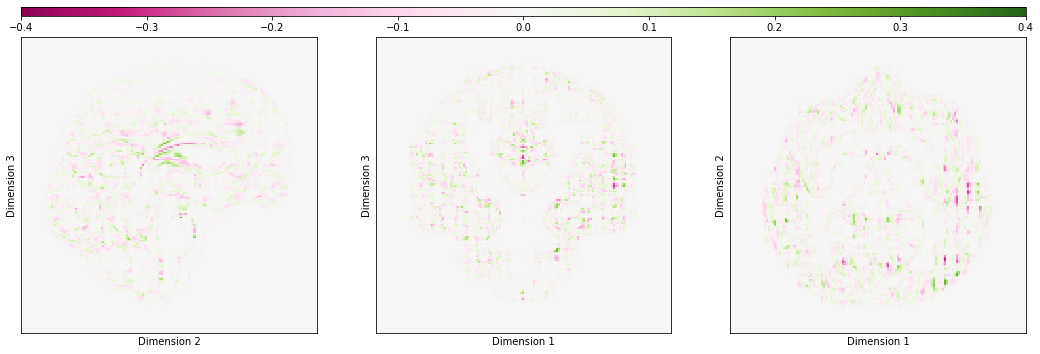

In [118]:
print("Hallucination map in null space for interpolation:")
show_orthoslices(interp_hm_null.numpy().squeeze(), IMG_cross, cmap = "PiYG", vmin = -0.4, vmax = 0.4)

print("Hallucination map in null space for model-based SRR:")
show_orthoslices(mbSRR_hm_null.numpy().squeeze(), IMG_cross, cmap = "PiYG", vmin = -0.4, vmax = 0.4)

print("Hallucination map in null space for PRETTIER:")
show_orthoslices(prettier_hm_null.numpy().squeeze(), IMG_cross, cmap = "PiYG", vmin = -0.4, vmax = 0.4)